## Select path in MPAS mesh

Find all the edges and vertices in the MPAS mesh that connect two endpoints (vertices) with the shortest distance (local optimization).

__Algorithm:__

1. Find the two vertices V1 and V2 that are closest to the two end points P1 and P2
2. Start from V1, loop over the three adjacent edges, find the edge E that is closer to V2
3. Record E, move to the second vertex V_e of the edge E, loop over the other two adjacent edges, find the edge E that is closer to V2
4. Repeat step 3
5. Stop when the V_e is V2

In [1]:
from mpasanalysis import *
%matplotlib inline

In [2]:
# load dataset
grd_file = os.environ['HOME']+'/data/mpas/grids/oEC60to30v3_60layer.170905.nc'
f_grd = Dataset(grd_file, 'r')

In [3]:
# read grid information
lonVertex = np.degrees(f_grd.variables['lonVertex'][:])
latVertex = np.degrees(f_grd.variables['latVertex'][:])
lonEdge = np.degrees(f_grd.variables['lonEdge'][:])
latEdge = np.degrees(f_grd.variables['latEdge'][:])
indexToEdgeID = f_grd.variables['indexToEdgeID'][:]
indexToVertexID = f_grd.variables['indexToVertexID'][:]
edgesOnVertex = f_grd.variables['edgesOnVertex'][:]
verticesOnEdge = f_grd.variables['verticesOnEdge'][:]

In [4]:
def get_index_latlon(loni, lati, lon_arr, lat_arr):
    pts = np.array(list(zip(loni,lati)))
    tree = spatial.KDTree(list(zip(lon_arr, lat_arr)))
    p = tree.query(pts)
    cidx = p[1]
    return cidx[0]

In [5]:
def select_path(lonP0, latP0, lonP1, latP1,
                lonVertex, latVertex, lonEdge, latEdge,
                indexToEdgeID, indexToVertexID,
                edgesOnVertex, verticesOnEdge,
                debug_info=False):
    """ Select the edges and vertices on a path given by the two endpoints.
    """
    idxP0 = get_index_latlon([lonP0], [latP0], lonVertex, latVertex)
    idxP1 = get_index_latlon([lonP1], [latP1], lonVertex, latVertex)
    print('Vertex closest to P0: {:4.1f} {:4.1f}'.format(lonVertex[idxP0], latVertex[idxP0]))
    print('Vertex closest to P1: {:4.1f} {:4.1f}'.format(lonVertex[idxP1], latVertex[idxP1]))
    # initialize arrays
    edges_on_path        = []
    idx_edges_on_path    = []
    vertices_on_path     = []
    idx_vertices_on_path = []
    # start from vertex P0
    idx_vertex_now = idxP0
    # record vortices on path and the indices
    vertices_on_path.append(indexToVertexID[idx_vertex_now])
    idx_vertices_on_path.append(idx_vertex_now)
    if debug_info:
        print('Vertex on path: {:4.1f} {:4.1f}'.format(lonVertex[idx_vertex_now], latVertex[idx_vertex_now]))

    # continue if not reached P1
    while idx_vertex_now != idxP1:

        # find the indices of the three edges on vertex
        edge_arr     = edgesOnVertex[idx_vertex_now,:]
        idx_edge_arr = [np.where(indexToEdgeID==val)[0][0] for val in edge_arr]
        # print the location of the three edges
        if debug_info:
            for i in np.arange(len(idx_edge_arr)):
                print('   Edge {:d}: {:4.1f} {:4.1f}'.\
                      format(i, lonEdge[idx_edge_arr[i]], latEdge[idx_edge_arr[i]]))
        # choose the edge from the three that is closest to vertex P1
        dist = [gc_distance(loni, lati, lonP1, latP1) \
                for (loni, lati) in zip(lonEdge[idx_edge_arr], latEdge[idx_edge_arr])]
        idx3_next     = np.argmin(dist)
        edge_next     = edge_arr[idx3_next]
        idx_edge_next = np.where(indexToEdgeID==edge_next)[0][0]
        # print the edge on path
        if debug_info:
            print('Edge on path: [Edge {:d}] {:4.1f} {:4.1f}'.\
                  format(idx3_next, lonEdge[idx_edge_arr[idx3_next]], latEdge[idx_edge_arr[idx3_next]]))
        # record edges on path and the indices
        edges_on_path.append(edge_next)
        idx_edges_on_path.append(idx_edge_next)

        # find the other vertex on this edge
        vertex_arr      = verticesOnEdge[idx_edge_next,:]
        vertex_next     = vertex_arr[vertex_arr!=indexToVertexID[idx_vertex_now]][0]
        idx_vertex_next = np.where(indexToVertexID==vertex_next)[0][0]
        # record vortices on path and the indices
        vertices_on_path.append(vertex_next)
        idx_vertices_on_path.append(idx_vertex_next)
        if debug_info:
            print('Vertex on path: {:4.1f} {:4.1f}'.\
                  format(lonVertex[idx_vertex_next], latVertex[idx_vertex_next]))
        # move to next vertex
        idx_vertex_now  = idx_vertex_next

    out = {'edge': edges_on_path,
           'edge_idx': idx_edges_on_path,
           'vertex': vertices_on_path,
           'vertex_idx': idx_vertices_on_path}
    return out


In [6]:
# set endpoints
lonP0, latP0 = 304.5, 53.5
lonP1, latP1 = 312, 61
# lonP0, latP0 = 296, 63
# lonP1, latP1 = 320, 50
print('Endpoints:')
print('    P0: {:4.1f} {:4.1f}'.format(lonP0, latP0))
print('    P1: {:4.1f} {:4.1f}'.format(lonP1, latP1))

Endpoints:
    P0: 304.5 53.5
    P1: 312.0 61.0


In [7]:
# get the path
out = select_path(lonP0, latP0, lonP1, latP1,
                  lonVertex, latVertex, lonEdge, latEdge,
                  indexToEdgeID, indexToVertexID,
                  edgesOnVertex, verticesOnEdge,
                  debug_info=False) 
idx_path_edge = out['edge_idx']
idx_path_vertex = out['vertex_idx']

Vertex closest to P0: 304.6 53.4
Vertex closest to P1: 312.1 61.0


### Plot the path 

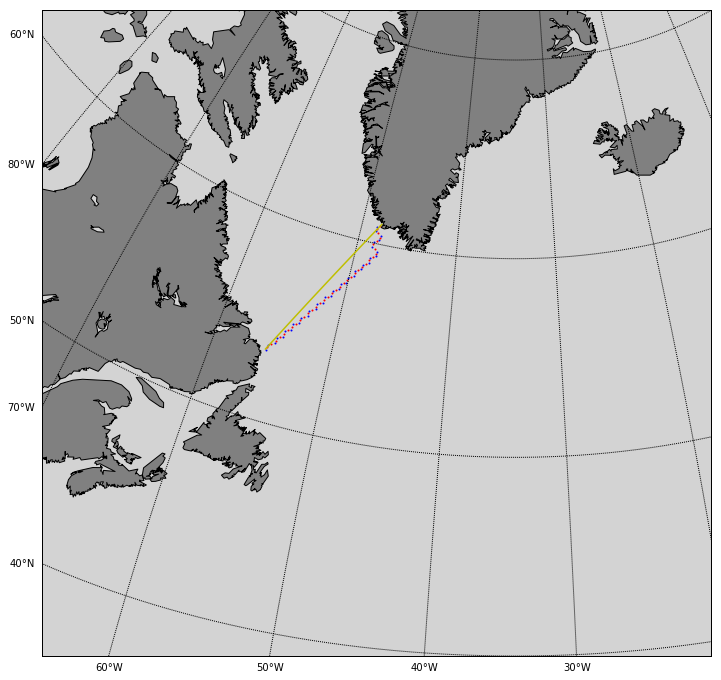

In [8]:
# test
lon_edge   = lonEdge[idx_path_edge]
lat_edge   = latEdge[idx_path_edge]
lon_vertex = lonVertex[idx_path_vertex]
lat_vertex = latVertex[idx_path_vertex]
# plot the region
plt.figure(figsize=[12,12])
region_obj = region_latlon('LabSea')
lon_ll, lat_ll, lon_ur, lat_ur = region_obj.lon_ll, region_obj.lat_ll, region_obj.lon_ur, region_obj.lat_ur
lon_c = 0.5*(lon_ll+lon_ur)
lat_c = 0.5*(lat_ll+lat_ur)
m = Basemap(projection='cass', llcrnrlon=lon_ll, llcrnrlat=lat_ll,
            urcrnrlon=lon_ur, urcrnrlat=lat_ur, resolution='l', lon_0=lon_c, lat_0=lat_c )
m.drawcoastlines()
m.drawmapboundary(fill_color='lightgray')
m.fillcontinents(color='gray',lake_color='lightgray')
m.drawparallels(np.arange(-90.,91.,10), labels=[1,0,0,1])
m.drawmeridians(np.arange(0.,361.,10), labels=[1,0,0,1])
m.drawgreatcircle(lonP0, latP0, lonP1, latP1, color='y')
x_e, y_e = m(lon_edge, lat_edge)
m.scatter(x_e, y_e, s=1, c='r')
x_v, y_v = m(lon_vertex, lat_vertex)
m.scatter(x_v, y_v, s=1, c='b')